# Select the final label set that can be used to generate profiles for entities of a desired type
In this notebook, we will utilize the embeddings we created for the entities to further narrow down the labels that we previously created and filtered. This will give us a final set of labels that can be used to generate "profiles" for entities of a desired type by selecting labels from the final label set that a given entity matches. In this notebook, we will now ask for a desired type to profile on so that we don't create label sets for all types in the knowledge graph.

### Pre-requisite steps to run this notebook
1. Run the candidate_label_creation, candidate_filter, and HAS_entity_embeddings notebooks first (these have their own pre-reqs). We will use files that were created by those notebooks in this notebook.

In [2]:
import os
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from utility import run_command
from utility import rename_cols_and_overwrite_id
from label_discretization import discretize_labels
from gensim.models import KeyedVectors

### Parameters
**REQUIRED**  
**type_to_profile**: The type that we will create a label set for, and therefore be able to create entity profiles for. This should be a string denoting a Q-node. e.g. if we want to create profiles for beers, we would set type_to_profile="Q44" (Q44=beer).  
**work_dir**: path to work dir that was specified in the candidate_label_creation, candidate_filter, and HAS_embeddings notebooks. We will utilize files that were saved by those previous notebooks, and also save files created by this notebook here.  
**item_file**: file path for the file that contains entity to entity relationships (e.g. wikibase-item)  
**time_file**: file path for the file that contains entity to time-type values  
**quantity_file**: file path for the file that contains entity to quantity-type values  
**label_file**: file path for the file that contains wikidata labels  
**store_dir**: path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

**OPTIONAL**  
**In-progress... this is currently not used.**  
*string_file*: file path for the file that contains entity to string-type values  

In [3]:
data_dir = "../../Q44/data" # my data files are all in the same directory, so I'll reuse this path prefix

# **REQUIRED**
type_to_profile = "Q44"
work_dir = "../../Q44/profiler_work"
item_file = "{}/Q44.part.wikibase-item.tsv".format(data_dir)
time_file = "{}/Q44.part.time.tsv".format(data_dir)
quantity_file = "{}/Q44.part.quantity.tsv".format(data_dir)
label_file = "{}/Q44.label.en.tsv".format(data_dir)
store_dir = "../../Q44"

# **optional**
string_file = None #"{}/Q44.part.string.tsv".format(data_dir)

### Process parameters and set up variables / file names

In [4]:
# Ensure paths are absolute
item_file = os.path.abspath(item_file)
time_file = os.path.abspath(time_file)
quantity_file = os.path.abspath(quantity_file)
label_file = os.path.abspath(label_file)
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
if string_file:
    string_file = os.path.abspath(string_file)
    
# Create directories
output_dir = "{}/final_label_sets/{}".format(work_dir, type_to_profile)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
label_set_work_dir = "{}/work".format(output_dir)
if not os.path.exists(label_set_work_dir):
    os.makedirs(label_set_work_dir)
label_set_final_dir = "{}/final".format(output_dir)
if not os.path.exists(label_set_final_dir):
    os.makedirs(label_set_final_dir)
    
# adding some environment variables we'll be using frequently
os.environ['ITEM_FILE'] = item_file
os.environ['TIME_FILE'] = time_file
os.environ['QUANTITY_FILE'] = quantity_file
os.environ['LABEL_FILE'] = label_file
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['FILTERED_LABELS'] = "{}/candidate_filter".format(work_dir)
os.environ['LABEL_CREATION_DIR'] = "{}/label_creation".format(work_dir)
os.environ['TYPE'] = type_to_profile
os.environ['WORK'] = label_set_work_dir
os.environ['OUT'] = label_set_final_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

## 1. Get labels that abstract entities of the type we want to profile and find the entities that match each of those labels

**this could possibly be a separate notebook or just code moved out of notebook.**

**Actually we could do this in earlier steps along the way - like in label creation... For scalability, if we did this we might need to move the type_to_profile decision to there so we don't enumerate all labels and their entities (this would blow up when we get to RALs).** 

**since we didn't keep quantities and times separate for ravls and rails, the final label set won't be able to disambiguate whether the value for these is a time or quantity - this actually isn't much of a problem since the property will be able to disambiguate time versus quantity, however it means that we'll have to look in a concatenated quantities/times file when creating a profile for an entity.**

We will later choose from these labels to form the final label set, and we will do this based off of several formulas that take into account the entities that match each label.

Also, we need each label to have a unique identifier (again this is something that we could have done along the way in earlier notebooks - would simplify some queries). We'll add a column for this here as well.

### 1.1 RELs

In [342]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_rel_item_filtered.tsv \
-i $ITEM_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv -i $LABEL_FILE \
-o $WORK/candidate_RELs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type:`'"$TYPE"'`)-[l1 {label:p, prop_label:p_lab, id:label_id}]->(val), `'"$ITEM_FILE"'`: (e)-[l2 {label:p}]->(val), type: (e)-[]->(type), `'"$LABEL_FILE"'`: (type)-[:label]->(type_lab), `'"$LABEL_FILE"'`: (val)-[:label]->(val_lab)' \
--return 'distinct printf("REL-%s", label_id) as node1, "pos_entity" as label, e as node2, type as type, type_lab as type_label, p as prop, p_lab as prop_label, val as value, val_lab as value_label, "_" as id' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en" AND val_lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'type, p, value, e'

In [343]:
!kgtk add-id -i $WORK/candidate_RELs_and_their_entities.tsv -o $WORK/candidate_RELs_and_their_entities.tsv --overwrite-id

In [344]:
labels_df = pd.read_csv("{}/candidate_RELs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.node1.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 36
number of rows (labels can have multiple matching entities): 53


,node1,label,node2,type,type_label,prop,prop_label,value,value_label,id
0,REL-E22327,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q93552342,'Vergina Lager'@en,E1
1,REL-E22328,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q93557205,'Vergina Red'@en,E2
2,REL-E22329,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q93558270,'Vergina Porfyra'@en,E3
3,REL-E22330,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q93559285,'Vergina Weiss'@en,E4
4,REL-E22331,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q93560567,'Vergina XXX Black'@en,E5
5,REL-E22332,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q93560976,'Thracian Malt'@en,E6
6,REL-E22333,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q97412285,'Vergina Alcohol Free'@en,E7
7,REL-E22334,pos_entity,Q12877510,Q44,'beer'@en,P112,'founded by'@en,Q90449270,'Demetri Politopoulos'@en,E8
8,REL-E38780,pos_entity,Q93552342,Q44,'beer'@en,P127,'owned by'@en,Q12877510,'Macedonian Thrace Brewery'@en,E9
9,REL-E38780,pos_entity,Q93557205,Q44,'beer'@en,P127,'owned by'@en,Q12877510,'Macedonian Thrace Brewery'@en,E10


### 1.2 AVLs - quantities

In [315]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_avl_quantity_filtered.tsv \
-i $QUANTITY_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv -i $LABEL_FILE \
-o $WORK/candidate_quantity_AVLs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type:`'"$TYPE"'`)-[l1 {label:p, prop_label:p_lab, id:label_id, si_units:label_si, wd_units:label_wd}]->(label_quantity_num), `'"$QUANTITY_FILE"'`: (e)-[l2 {label:p}]->(val), type: (e)-[]->(type), `'"$LABEL_FILE"'`: (type)-[:label]->(type_lab)' \
--return 'distinct printf("AVL-quantity-%s", label_id) as node1, "pos_entity" as label, e as node2, type as type, type_lab as type_label, p as prop, p_lab as prop_label, label_quantity_num as value, label_si as si_units, label_wd as wd_units, "_" as id' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en" AND kgtk_quantity_number(val)=label_quantity_num AND ( (kgtk_quantity_si_units(val) is null AND label_si="") OR (kgtk_quantity_si_units(val)=label_si) ) AND ( (kgtk_quantity_wd_units(val) is null AND label_wd="") OR (kgtk_quantity_wd_units(val)=label_wd) )' \
--order-by 'type, prop, value, si_units, wd_units, e'


In [316]:
!kgtk add-id -i $WORK/candidate_quantity_AVLs_and_their_entities.tsv -o $WORK/candidate_quantity_AVLs_and_their_entities.tsv --overwrite-id

In [317]:
labels_df = pd.read_csv("{}/candidate_quantity_AVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.node1.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))


number of distinct labels: 7
number of rows (labels can have multiple matching entities): 7


,node1,label,node2,type,type_label,prop,prop_label,value,si_units,wd_units,id
0,AVL-quantity-E51037,pos_entity,Q12877510,Q44,'beer'@en,P2226,'market capitalization'@en,3896025.7,,,E1
1,AVL-quantity-E51038,pos_entity,Q97412285,Q44,'beer'@en,P2665,'alcohol by volume'@en,0.4,,Q2080811,E2
2,AVL-quantity-E51040,pos_entity,Q93559285,Q44,'beer'@en,P2665,'alcohol by volume'@en,5.4,,Q2080811,E3
3,AVL-quantity-E51041,pos_entity,Q93560567,Q44,'beer'@en,P2665,'alcohol by volume'@en,5.5,,Q2080811,E4
4,AVL-quantity-E51042,pos_entity,Q93557205,Q44,'beer'@en,P2665,'alcohol by volume'@en,5.8,,Q2080811,E5
5,AVL-quantity-E51043,pos_entity,Q93558270,Q44,'beer'@en,P2665,'alcohol by volume'@en,6.3,,Q2080811,E6
6,AVL-quantity-E51046,pos_entity,Q93557205,Q44,'beer'@en,P6088,'beer bitterness'@en,29.5,,,E7


### 1.3 AVLs - times

In [322]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_avl_time.year_filtered.tsv \
-i $TIME_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv -i $LABEL_FILE\
-o $WORK/candidate_time.year_AVLs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type:`'"$TYPE"'`)-[l1 {label:p, prop_label:p_lab, id:label_id}]->(label_year), `'"$TIME_FILE"'`: (e)-[l2 {label:p}]->(val), type: (e)-[]->(type), `'"$LABEL_FILE"'`: (type)-[:label]->(type_lab)' \
--return 'distinct printf("AVL-time.year-%s", label_id) as node1, "pos_entity" as label, e as node2, type as type, type_lab as type_label, p as prop, p_lab as prop_label, label_year as value, "_" as id' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en" AND kgtk_date_year(val)=label_year' \
--order-by 'type, prop, value, e'

In [323]:
!kgtk add-id -i $WORK/candidate_time.year_AVLs_and_their_entities.tsv -o $WORK/candidate_time.year_AVLs_and_their_entities.tsv --overwrite-id

In [324]:
labels_df = pd.read_csv("{}/candidate_time.year_AVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.node1.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 7
number of rows (labels can have multiple matching entities): 7


,node1,label,node2,type,type_label,prop,prop_label,value,id
0,AVL-time.year-E321,pos_entity,Q12877510,Q44,'beer'@en,P571,'inception'@en,1996,E1
1,AVL-time.year-E322,pos_entity,Q93552342,Q44,'beer'@en,P571,'inception'@en,1998,E2
2,AVL-time.year-E323,pos_entity,Q93557205,Q44,'beer'@en,P571,'inception'@en,2001,E3
3,AVL-time.year-E324,pos_entity,Q93559285,Q44,'beer'@en,P571,'inception'@en,2003,E4
4,AVL-time.year-E325,pos_entity,Q93558270,Q44,'beer'@en,P571,'inception'@en,2013,E5
5,AVL-time.year-E326,pos_entity,Q93560567,Q44,'beer'@en,P571,'inception'@en,2017,E6
6,AVL-time.year-E327,pos_entity,Q97412285,Q44,'beer'@en,P571,'inception'@en,2020,E7


### 1.4 AILs - quantities

In [328]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_ail_quantity_filtered.tsv \
-i $QUANTITY_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv -i $LABEL_FILE \
-o $WORK/candidate_quantity_AILs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type:`'"$TYPE"'`)-[l1 {label:p, prop_label:p_lab, id:label_id, upper_bound:ub, si_units:label_si, wd_units:label_wd}]->(lb), `'"$QUANTITY_FILE"'`: (e)-[l2 {label:p}]->(val), type: (e)-[]->(type), `'"$LABEL_FILE"'`: (type)-[:label]->(type_lab)' \
--return 'distinct printf("AIL-quantity-%s", label_id) as node1, "pos_entity" as label, e as node2, type as type, type_lab as type_label, p as prop, p_lab as prop_label, lb as value_lb, ub as value_ub, label_si as si_units, label_wd as wd_units, "_" as id' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en" AND (not lb OR kgtk_quantity_number(val) >= kgtk_quantity_number(lb)) AND (not ub OR kgtk_quantity_number(ub) >= kgtk_quantity_number(val)) AND ( (kgtk_quantity_si_units(val) is null AND label_si="") OR (kgtk_quantity_si_units(val)=label_si) ) AND ( (kgtk_quantity_wd_units(val) is null AND label_wd="") OR (kgtk_quantity_wd_units(val)=label_wd) )' \
--order-by 'type, prop, value_lb, si_units, wd_units, e'


In [329]:
!kgtk add-id -i $WORK/candidate_quantity_AILs_and_their_entities.tsv -o $WORK/candidate_quantity_AILs_and_their_entities.tsv --overwrite-id

In [330]:
labels_df = pd.read_csv("{}/candidate_quantity_AILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.node1.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 6
number of rows (labels can have multiple matching entities): 12


,node1,label,node2,type,type_label,prop,prop_label,value_lb,value_ub,si_units,wd_units,id
0,AIL-quantity-E401,pos_entity,Q12877510,Q44,'beer'@en,P2226,'market capitalization'@en,,,,,E1
1,AIL-quantity-E402,pos_entity,Q97412285,Q44,'beer'@en,P2665,'alcohol by volume'@en,,2.7,,Q2080811,E2
2,AIL-quantity-E1254,pos_entity,Q93552342,Q44,'beer'@en,P2665,'alcohol by volume'@en,2.7,,,Q2080811,E3
3,AIL-quantity-E1254,pos_entity,Q93557205,Q44,'beer'@en,P2665,'alcohol by volume'@en,2.7,,,Q2080811,E4
4,AIL-quantity-E1254,pos_entity,Q93558270,Q44,'beer'@en,P2665,'alcohol by volume'@en,2.7,,,Q2080811,E5
5,AIL-quantity-E1254,pos_entity,Q93559285,Q44,'beer'@en,P2665,'alcohol by volume'@en,2.7,,,Q2080811,E6
6,AIL-quantity-E1254,pos_entity,Q93560567,Q44,'beer'@en,P2665,'alcohol by volume'@en,2.7,,,Q2080811,E7
7,AIL-quantity-E403,pos_entity,Q93559285,Q44,'beer'@en,P6088,'beer bitterness'@en,,17.5,,,E8
8,AIL-quantity-E722,pos_entity,Q93552342,Q44,'beer'@en,P6088,'beer bitterness'@en,17.5,23,,,E9
9,AIL-quantity-E722,pos_entity,Q93558270,Q44,'beer'@en,P6088,'beer bitterness'@en,17.5,23,,,E10


### 1.5 AILs - times

In [331]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_ail_time.year_filtered.tsv \
-i $TIME_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv -i $LABEL_FILE \
-o $WORK/candidate_time.year_AILs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type:`'"$TYPE"'`)-[l1 {label:p, prop_label:p_lab, id:label_id, upper_bound:ub}]->(lb), `'"$TIME_FILE"'`: (e)-[l2 {label:p}]->(val), type: (e)-[]->(type), `'"$LABEL_FILE"'`: (type)-[:label]->(type_lab)' \
--return 'distinct printf("AIL-time.year-%s", label_id) as node1, "pos_entity" as label, e as node2, type as type, type_lab as type_label, p as prop, p_lab as prop_label, lb as value_lb, ub as value_ub, "_" as id' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en" AND (not lb OR kgtk_date_year(val) >= kgtk_quantity_number(lb)) AND (not ub OR kgtk_quantity_number(ub) >= kgtk_date_year(val))' \
--order-by 'type, prop, value_lb, e'


In [332]:
!kgtk add-id -i $WORK/candidate_time.year_AILs_and_their_entities.tsv -o $WORK/candidate_time.year_AILs_and_their_entities.tsv --overwrite-id

In [333]:
labels_df = pd.read_csv("{}/candidate_time.year_AILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.node1.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 3
number of rows (labels can have multiple matching entities): 7


,node1,label,node2,type,type_label,prop,prop_label,value_lb,value_ub,id
0,AIL-time.year-E75,pos_entity,Q12877510,Q44,'beer'@en,P571,'inception'@en,,2008,E1
1,AIL-time.year-E75,pos_entity,Q93552342,Q44,'beer'@en,P571,'inception'@en,,2008,E2
2,AIL-time.year-E75,pos_entity,Q93557205,Q44,'beer'@en,P571,'inception'@en,,2008,E3
3,AIL-time.year-E75,pos_entity,Q93559285,Q44,'beer'@en,P571,'inception'@en,,2008,E4
4,AIL-time.year-E25,pos_entity,Q93558270,Q44,'beer'@en,P571,'inception'@en,2008,2015,E5
5,AIL-time.year-E47,pos_entity,Q93560567,Q44,'beer'@en,P571,'inception'@en,2015,,E6
6,AIL-time.year-E47,pos_entity,Q97412285,Q44,'beer'@en,P571,'inception'@en,2015,,E7


### 1.6 RAVLs - quantities and times
both quantities and times here because we mixed them together in the label creation step...

In [390]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_ravl_filtered.tsv \
-i $LABEL_CREATION_DIR/entity_AVLs_all.tsv -i $ITEM_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv -i $LABEL_FILE \
-o $WORK/candidate_RAVLs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type1:`'"$TYPE"'`)-[l1 {label:p1, id:label_id, prop2:p2, prop2_label:p2_lab, val:val, si_units:si, wd_units:wd}]->(type2), `'"$ITEM_FILE"'`: (e1)-[l2 {label:p1}]->(e2), AVLs_all: (type2)-[l3 {label:p2, entity:e2, si_units:si, wd_units:wd}]->(val), type: (e1)-[]->(type1), `'"$LABEL_FILE"'`: (type1)-[:label]->(type1_lab), `'"$LABEL_FILE"'`: (p1)-[:label]->(p1_lab), `'"$LABEL_FILE"'`: (type2)-[:label]->(type2_lab)' \
--return 'distinct printf("RAVL-%s", label_id) as node1, "pos_entity" as label, e1 as node2, type1 as type, type1_lab as type_label, p1 as prop, p1_lab as prop_label, type2 as value, type2_lab as value_label, p2 as prop2, p2_lab as prop2_label, val as value2, si as si_units, wd as wd_units, "_" as id' \
--where 'type1_lab.kgtk_lqstring_lang_suffix = "en" AND p1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'type1, p1, type2, p2, value2, si, wd, e1'

Note - below we need to create a temporary file to add ids to avoid what seems like a bug... wrote a github issue for this.

In [391]:
!kgtk add-id -i $WORK/candidate_RAVLs_and_their_entities.tsv -o $WORK/candidate_RAVLs_and_their_entities_temp.tsv --overwrite-id \
&& mv $WORK/candidate_RAVLs_and_their_entities_temp.tsv $WORK/candidate_RAVLs_and_their_entities.tsv

In [392]:
labels_df = pd.read_csv("{}/candidate_RAVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.node1.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 1342
number of rows (labels can have multiple matching entities): 5140


,node1,label,node2,type,type_label,prop,prop_label,value,value_label,prop2,prop2_label,value2,si_units,wd_units,id
0,RAVL-E630939,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P2665,'alcohol by volume'@en,5.4,,Q2080811,E1
1,RAVL-E630942,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q15075508,'beer brand'@en,P2665,'alcohol by volume'@en,0.4,,Q2080811,E2
2,RAVL-E630944,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q15075508,'beer brand'@en,P2665,'alcohol by volume'@en,5.4,,Q2080811,E3
3,RAVL-E630945,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q15075508,'beer brand'@en,P2665,'alcohol by volume'@en,5.5,,Q2080811,E4
4,RAVL-E630946,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q15075508,'beer brand'@en,P2665,'alcohol by volume'@en,5.8,,Q2080811,E5
5,RAVL-E630947,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q15075508,'beer brand'@en,P2665,'alcohol by volume'@en,6.3,,Q2080811,E6
6,RAVL-E630957,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q15075508,'beer brand'@en,P6088,'beer bitterness'@en,29.5,,,E7
7,RAVL-E630960,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q154,'alcoholic beverage'@en,P2665,'alcohol by volume'@en,5.4,,Q2080811,E8
8,RAVL-E630961,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q154,'alcoholic beverage'@en,P2665,'alcohol by volume'@en,5.5,,Q2080811,E9
9,RAVL-E630962,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q154,'alcoholic beverage'@en,P2665,'alcohol by volume'@en,5.8,,Q2080811,E10


### 1.7 RAILs - quantities and times
both quantities and times here because we mixed them together in the label creation step...

In [339]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_rail_filtered.tsv \
-i $LABEL_CREATION_DIR/entity_AILs_all.tsv -i $ITEM_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv -i $LABEL_FILE \
-o $WORK/candidate_RAILs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type1:`'"$TYPE"'`)-[l1 {label:p1, id:label_id, prop2:p2, prop2_label:p2_lab, lower_bound:lb, upper_bound:ub, si_units:si, wd_units:wd}]->(type2), `'"$ITEM_FILE"'`: (e1)-[l2 {label:p1}]->(e2), AILs_all: (type2)-[l3 {label:p2, entity:e2, lower_bound:lb, upper_bound:ub, si_units:si, wd_units:wd}]->(), type: (e1)-[]->(type1), `'"$LABEL_FILE"'`: (type1)-[:label]->(type1_lab), `'"$LABEL_FILE"'`: (p1)-[:label]->(p1_lab), `'"$LABEL_FILE"'`: (type2)-[:label]->(type2_lab)' \
--return 'distinct printf("RAIL-%s", label_id) as node1, "pos_entity" as label, e1 as node2, type1 as type, type1_lab as type_label, p1 as prop, p1_lab as prop_label, type2 as value, type2_lab as value_label, p2 as prop2, p2_lab as prop2_label, lb as value2_lb, ub as value2_ub, si as si_units, wd as wd_units, "_" as id' \
--where 'type1_lab.kgtk_lqstring_lang_suffix = "en" AND p1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'type1, p1, type2, p2, lb, ub, si, wd, e1'

In [340]:
!kgtk add-id -i $WORK/candidate_RAILs_and_their_entities.tsv -o $WORK/candidate_RAILs_and_their_entities_temp.tsv --overwrite-id \
&& mv $WORK/candidate_RAILs_and_their_entities_temp.tsv $WORK/candidate_RAILs_and_their_entities.tsv

In [341]:
labels_df = pd.read_csv("{}/candidate_RAILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.node1.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 407
number of rows (labels can have multiple matching entities): 1212


,node1,label,node2,type,type_label,prop,prop_label,value,value_label,prop2,prop2_label,value2_lb,value2_ub,si_units,wd_units,id
0,RAIL-E29771,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P2665,'alcohol by volume'@en,,,,Q2080811,E1
1,RAIL-E29772,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P571,'inception'@en,,,,,E2
2,RAIL-E29773,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P6088,'beer bitterness'@en,,,,,E3
3,RAIL-E29776,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q15075508,'beer brand'@en,P571,'inception'@en,1945.5,2008,,,E4
4,RAIL-E29777,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q15075508,'beer brand'@en,P571,'inception'@en,2008,,,,E5
5,RAIL-E29778,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q15075508,'beer brand'@en,P6088,'beer bitterness'@en,,17.5,,,E6
6,RAIL-E29779,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q15075508,'beer brand'@en,P6088,'beer bitterness'@en,17.5,23,,,E7
7,RAIL-E29780,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q15075508,'beer brand'@en,P6088,'beer bitterness'@en,23,,,,E8
8,RAIL-E29781,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q152024,'malt'@en,P571,'inception'@en,,,,,E9
9,RAIL-E29782,pos_entity,Q12877510,Q44,'beer'@en,P1056,'product or material produced'@en,Q154,'alcoholic beverage'@en,P2665,'alcohol by volume'@en,,5.2,,Q2080811,E10


## 2. Get all entities of the type we are profiling

In [345]:
!kgtk query -i $LABEL_CREATION_DIR/type_mapping.tsv -i $LABEL_FILE \
-o $WORK/entities_in_type.tsv --graph-cache $STORE \
--match 'type: (entity)-[]->(type:`'"$TYPE"'`), `'"$LABEL_FILE"'`: (entity)-[:label]->(lab)' \
--return 'distinct entity as entity, lab as label' \
--where 'lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'entity'

In [346]:
entities_in_type_df = pd.read_csv("{}/entities_in_type.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of entities: {}".format(entities_in_type_df.shape[0]))
display(entities_in_type_df.loc[:10].fillna(""))

number of entities: 8


,entity,label
0,Q12877510,'Macedonian Thrace Brewery'@en
1,Q61976614,'Rastrum'@en
2,Q93552342,'Vergina Lager'@en
3,Q93557205,'Vergina Red'@en
4,Q93558270,'Vergina Porfyra'@en
5,Q93559285,'Vergina Weiss'@en
6,Q93560567,'Vergina XXX Black'@en
7,Q97412285,'Vergina Alcohol Free'@en


## 3. Load information needed into Python variables.
1. Load dictionary of all labels found in step 1 above along with their corresponding positive entities (note, performance of this step might be improved if we do it along the way in step 1)
2. Load set of all entities of the type we are profiling (compiled in step 2)
3. Load the keyed vector of entity embeddings (created in HAS_entity_embeddings notebook)

In [393]:
# load labels from step 1 into single dataframe
labels_df = pd.read_csv("{}/candidate_RELs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna("")
labels_df = labels_df.append(pd.read_csv("{}/candidate_quantity_AVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))
labels_df = labels_df.append(pd.read_csv("{}/candidate_time.year_AVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))
labels_df = labels_df.append(pd.read_csv("{}/candidate_quantity_AILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))
labels_df = labels_df.append(pd.read_csv("{}/candidate_time.year_AILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))
labels_df = labels_df.append(pd.read_csv("{}/candidate_RAVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))
labels_df = labels_df.append(pd.read_csv("{}/candidate_RAILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))

# create dictionary of label_id --> set of matching entities
# using groupby is not the most efficient, but more concise
label_to_entities = labels_df.groupby("node1")["node2"].apply(set).to_dict()
print("total number of candidate labels for profiling entities of type {}: {}".format(type_to_profile, len(label_to_entities)))

# look up number of entities of the type we are profiling - looking to a file we created in label creation notebook
all_ents_in_type = set(pd.read_csv("{}/entities_in_type.tsv".format(os.environ['WORK']), delimiter = '\t').entity)
print("Loaded set of all entities of the type we are profiling ({} total)".format(len(all_ents_in_type)))

# load embeddings created in the embeddings notebook
entity_embeddings = KeyedVectors.load("{}/HAS_embeddings/entity_embeddings.kv".format(work_dir))
print("Loaded entity embeddings")

total number of candidate labels for profiling entities of type Q44: 1808
Loaded set of all entities of the type we are profiling (8 total)
Loaded entity embeddings


## 4. Compute distinctiveness for each label
distinctiveness of a label = average similarity amongst its positive entities - average similarity between its positive and negative entities

**We are running into a slight issue here because of how few entities there are of type beer**: filtering cutoffs for support was .1 and .9. Because we have <11 beers, we don't filter out labels that have only one matching beer. When computing internal similarity, we end up trying to find average similarity between pairs of entities in a set that has only one entity. Options: 1. set internal similarity to 0 - this will make us have a preference against adding such labels to the label set. 2. set internal similarity to 1 - this reflects that we haven't paired any dissimilar entities together... however this may create a large preference for single-entity labels...

In [349]:
%%time
label_distinctiveness = {}
# todo - use comprehension instead of loop
for label, pos_ents in label_to_entities.items():
    # average internal similarity
    if len(pos_ents) < 2:
        avg_internal_similarity = 1 # see note in section header above
    else:
#         # way 1 - might be faster...
#         pos_ent_embeds = entity_embeddings[pos_ents]
#         avg_internal_similarity = np.sum([np.sum(entity_embeddings.cosine_similarities(pos_ent_embeds[i], pos_ent_embeds[i+1:])) for i in range(len(pos_ents))]) / len(pos_ents)**2
        # way 2 - clearer...
        pairs = list(itertools.combinations(pos_ents,2))
        avg_internal_similarity = np.sum([entity_embeddings.similarity(e1, e2) for (e1, e2) in pairs]) / len(pairs)
    
    # average external similarity
    neg_ents = all_ents_in_type - pos_ents
    pairs = list(itertools.product(pos_ents, neg_ents))
    avg_external_similarity = np.sum([entity_embeddings.similarity(e1, e2) for (e1, e2) in pairs]) / len(pairs)
    
    label_distinctiveness[label] = avg_internal_similarity - avg_external_similarity
    

CPU times: user 385 ms, sys: 5.11 ms, total: 390 ms
Wall time: 399 ms


Let's take a look at the most distinctive labels

In [379]:
print("There are {} labels, and {} distinct values of distinctiveness.".format(len(label_distinctiveness),len(set(label_distinctiveness.values()))))
print("Most distinctive labels:")
most_distinct = sorted(label_distinctiveness.items(), key=lambda item: item[1], reverse=True)[:5]
display(most_distinct)
print("Looking at the top 1:")
label_id = most_distinct[0][0]
cols_to_display = ["type", "type_label", "prop", "prop_label", "value", "value_label", "value_lb", "value_ub", "prop2", "prop2_label", "value2", "value2_lb", "value2_ub", "si_units", "wd_units"]
display(labels_df.loc[labels_df["node1"]==label_id, cols_to_display].fillna("").iloc[[0]])
print("Positive entities for this label: {}".format(", ".join(label_to_entities[label_id])))
negatives = all_ents_in_type - label_to_entities[label_id]
print("Negative entities for this label: {}".format(", ".join(negatives)))

There are 1808 labels, and 17 distinct values of distinctiveness.
Most distinctive labels:


[('RAIL-E29829', 0.5552934578486851),
 ('RAIL-E29871', 0.5552934578486851),
 ('RAIL-E29872', 0.5552934578486851),
 ('RAIL-E29873', 0.5552934578486851),
 ('RAIL-E29874', 0.5552934578486851)]

Looking at the top 1:


,type,type_label,prop,prop_label,value,value_label,value_lb,value_ub,prop2,prop2_label,value2,value2_lb,value2_ub,si_units,wd_units
120,Q44,'beer'@en,P1343,'described by source'@en,Q191067,'article'@en,,,P577,'publication date'@en,,,1877.0,,


Positive entities for this label: Q61976614
Negative entities for this label: Q93558270, Q93557205, Q97412285, Q12877510, Q93552342, Q93559285, Q93560567


To see if this makes sense, we can look at the similarities amongst the entities

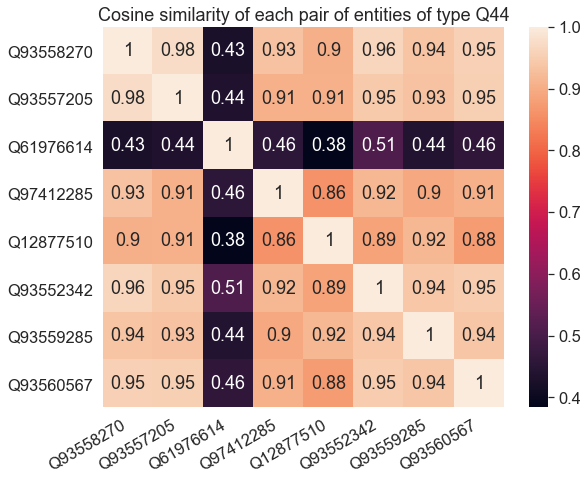

In [357]:
embeddings = entity_embeddings[all_ents_in_type]
similarity_mat = [entity_embeddings.cosine_similarities(e, embeddings) for e in embeddings]
labels = all_ents_in_type
fig, ax = plt.subplots(figsize=(9,7))
sns.set(font_scale=1.5)
sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Cosine similarity of each pair of entities of type {}".format(type_to_profile))
plt.show()

From the visual above, it makes sense that the most distinctive label separates Q61976614 from all other entities.

## 5. Iteratively choose labels to add to label set using formula
Choose label $l_i = argmax_{l_i \in L_t^c}{[d(l_i) + \delta * reward(l_i,L_t) - (1- \delta) * penalty(l_i,L_t)]}$

Where...
- $l_i$ is a label
- $L_t^c$ is the set of candidate labels relevant to the type $t$ that we are profiling
- $L_t$ is the set of labels relevant to the type $t$ that we have so far chosen to be in the final label set
- $d(l_i)$ is the distinctiveness of label $l_i$
- $reward(l_i,L_t)$ is a function that captures the potential increase in the total coverage of entities of type $t$ in the KG by the labels in $L_t$ if $l_i$ were to be added to it.
- $penalty(l_i,L_t)$ is a function that captures the potential increase in redundancy of labels in $L_t$ if $l_i$ were to be added to it.
- $\delta$ is a hyperparameter that adjusts if we care more about increasing total coverage versus minimizing redundancy

Functions for computing reward and penalty...

$reward(l_i,L_t) = \cfrac{|\bigcup_{l_j \in (L_t \cup \{l_i\})}{\varepsilon_t^{l_j}}|}{|\varepsilon_t|}$

Where...
- $\varepsilon_t^{l_j}$ is the set of entities of type $t$ that match label $l_j$
- $\varepsilon_t$ is the set of entities of type $t$

In [218]:
# note params are slightly different to avoid redundant computation
def reward(candidate_label, entities_covered_already):
    return len(entities_covered_already | label_to_entities[candidate_label]) / len(all_ents_in_type)

From the paper, "reward is the potential contribution of \[the label\] to the increase of the total
coverage of positive entities in the KG". The formula above doesn't exactly do that... yes, if the label increases the coverage of positive entities, then it will be higher, but if we already have good coverage and this label doesn't add anything new, reward will still be high. If we want a function that does what they explained, we could use something like $\cfrac{|\varepsilon_t^{l_i}| - |\varepsilon_t^{L_t} \cap \varepsilon_t^{l_i}|}{|\varepsilon_t|}$

$penalty(l_i,L_t) = \cfrac{\sum_{l_j \in L_t}{|\varepsilon_t^{l_i} \cap \varepsilon_t^{l_j}|}}{|L_t| * |\varepsilon_t|}$

In [201]:
# note params are slightly different to avoid redundant computation
def penalty(numerator, label_set):
    # when label set is empty, avoid divide by zero
    if len(label_set) == 0:
        return 0 
    return numerator / (len(label_set) * len(all_ents_in_type))

Iteratively choose labels

In [358]:
%%time
d = .5 # can make this a parameter
min_cutoff = 0 # can make this a parameter (though it isn't mentioned in the paper..)
covered_ents = set() # set of all entities covered by label set
label_set = []
candidate_labels = list(label_to_entities.keys())
penalty_numerator_for_label = {l : 0 for l in candidate_labels}
print("We have {} candidate labels to choose from".format(len(candidate_labels)))

for i in range(len(candidate_labels)):
    # Finding the best label
    vals = [label_distinctiveness[l] + d*reward(l, covered_ents) - (1-d)*penalty(penalty_numerator_for_label[l], label_set) for l in candidate_labels]
    max_val = np.max(vals)
    if max_val <= min_cutoff:
        break
    max_ix = np.random.choice(np.flatnonzero(vals == max_val))
    max_label = candidate_labels[max_ix]
    max_label_ents = label_to_entities[max_label]
    
    # Adding the label to final label set
    label_set.append(max_label)
    covered_ents = covered_ents | max_label_ents

    # Remove the label from candidate labels
    candidate_labels.pop(max_ix)
    
    # Update penalty numerator for labels that are still in the candidate list
    for l in candidate_labels:
        penalty_numerator_for_label[l] += len((label_to_entities[l] & max_label_ents))
        
#     print("Iteration {}:".format(i+1))
#     print("\tmax label: {}".format(max_label))
#     print("\t\tvalue: {}".format(max_val))
#     print("\t\tcovered entities: {}".format(", ".join(np.sort(list(max_label_ents)))))
#     print("\t\tdistinctiveness: {}".format(label_distinctiveness[max_label]))
#     print("\t\treward: {}".format(reward(max_label, covered_ents)))
#     print("\t\tpenalty: {}".format(penalty(penalty_numerator_for_label[max_label], label_set[:-1])))
    
print("Final label set has {} labels, covering {} / {} entities of type {} in the dataset".format(len(label_set), len(covered_ents), len(all_ents_in_type), type_to_profile))

We have 1808 candidate labels to choose from
Final label set has 1808 labels, covering 8 / 8 entities of type Q44 in the dataset
CPU times: user 2.75 s, sys: 19.7 ms, total: 2.77 s
Wall time: 2.83 s


## 6. Look at what profiles are created
**may make sense to eventually move to separate notebook.**


In [395]:
# NOTE - we can make max_labels_in_profile a notebook param
def print_profile_for_entity(entity, max_labels_in_profile = 5):
    print("Generating profile for entity: {}...".format(entity))

    # We can improve performance using a loop and stopping when we find however many labels we desire.
    # doing it this way here so we can see how many labels total are applicable to the entity
    matching_label_ids_ordered = [l for l in label_set if entity in label_to_entities[l]]

    print("There are {} labels in the final label set that match this entity.".format(len(matching_label_ids_ordered)))
    print("Choosing the top {}:".format(max_labels_in_profile))

    cols_to_display = ["type", "type_label", "prop", "prop_label", "value", "value_label", "value_lb", "value_ub", "prop2", "prop2_label", "value2", "value2_lb", "value2_ub", "si_units", "wd_units"]
    for label_id in matching_label_ids_ordered[:max_labels_in_profile]:
#         print("\nLabel ID: {}".format(label_id))
        display(labels_df.loc[labels_df["node1"]==label_id,cols_to_display].fillna("").iloc[[0]])
        print("positives for this label: {}".format(", ".join(label_to_entities[label_id])))

Because we had very few beers to profile, and one of them was much different than the others according to our embeddings, profiles for the non-outlier beers will consist of labels that are applicable to all of those non-outlier beers. Let's look at the generated profile for one of these non-outlier beers: Q93558270 - Vergina Porfyra

In [396]:
print_profile_for_entity("Q93558270")

Generating profile for entity: Q93558270...
There are 783 labels in the final label set that match this entity.
Choosing the top 5:


,type,type_label,prop,prop_label,value,value_label,value_lb,value_ub,prop2,prop2_label,value2,value2_lb,value2_ub,si_units,wd_units
4006,Q44,'beer'@en,P495,'country of origin'@en,Q51576574,'Mediterranean country'@en,,,P4841,'total fertility rate'@en,1.32,,,,


positives for this label: Q93558270, Q93557205, Q97412285, Q12877510, Q93559285, Q93552342, Q93560567


,type,type_label,prop,prop_label,value,value_label,value_lb,value_ub,prop2,prop2_label,value2,value2_lb,value2_ub,si_units,wd_units
2249,Q44,'beer'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,,,P1279,'inflation rate'@en,7.8,,,,Q11229


positives for this label: Q93558270, Q93557205, Q97412285, Q12877510, Q93559285, Q93552342, Q93560567


,type,type_label,prop,prop_label,value,value_label,value_lb,value_ub,prop2,prop2_label,value2,value2_lb,value2_ub,si_units,wd_units
2564,Q44,'beer'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,,,P2131,'nominal GDP'@en,7.600579e+09,,,,Q4917


positives for this label: Q93558270, Q93557205, Q97412285, Q12877510, Q93559285, Q93552342, Q93560567


,type,type_label,prop,prop_label,value,value_label,value_lb,value_ub,prop2,prop2_label,value2,value2_lb,value2_ub,si_units,wd_units
2585,Q44,'beer'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,,,P2131,'nominal GDP'@en,8.455611e+09,,,,Q4917


positives for this label: Q93558270, Q93557205, Q97412285, Q12877510, Q93559285, Q93552342, Q93560567


,type,type_label,prop,prop_label,value,value_label,value_lb,value_ub,prop2,prop2_label,value2,value2_lb,value2_ub,si_units,wd_units
1521,Q44,'beer'@en,P495,'country of origin'@en,Q179164,'unitary state'@en,,,P2219,'real gross domestic product growth rate'@en,0.0,,,,Q11229


positives for this label: Q93558270, Q93557205, Q97412285, Q12877510, Q93559285, Q93552342, Q93560567


Now let's look at the generated profile for the one outlier beer: Q61976614	- Rastrum. These will consist of labels that are only applicable to this beer if we used 1 for the special case in computing distinctiveness.

In [397]:
print_profile_for_entity("Q61976614")

Generating profile for entity: Q61976614...
There are 48 labels in the final label set that match this entity.
Choosing the top 5:


,type,type_label,prop,prop_label,value,value_label,value_lb,value_ub,prop2,prop2_label,value2,value2_lb,value2_ub,si_units,wd_units
163,Q44,'beer'@en,P17,'country'@en,Q3024240,'historical country'@en,,,P2046,'area'@en,,,,,Q712226


positives for this label: Q61976614


,type,type_label,prop,prop_label,value,value_label,value_lb,value_ub,prop2,prop2_label,value2,value2_lb,value2_ub,si_units,wd_units
160,Q44,'beer'@en,P17,'country'@en,Q26879769,'state in the Confederation of the Rhine'@en,,,P571,'inception'@en,,,,,


positives for this label: Q61976614


,type,type_label,prop,prop_label,value,value_label,value_lb,value_ub,prop2,prop2_label,value2,value2_lb,value2_ub,si_units,wd_units
17,Q44,'beer'@en,P1343,'described by source'@en,Q61442319,'Die Societätsbrauerei zum Waldschlößchen bei ...,,,,,,,,,


positives for this label: Q61976614


,type,type_label,prop,prop_label,value,value_label,value_lb,value_ub,prop2,prop2_label,value2,value2_lb,value2_ub,si_units,wd_units
371,Q44,'beer'@en,P276,'location'@en,Q22865,'independent city of Germany'@en,,,P2044,'elevation above sea level'@en,,,,,Q11573


positives for this label: Q61976614


,type,type_label,prop,prop_label,value,value_label,value_lb,value_ub,prop2,prop2_label,value2,value2_lb,value2_ub,si_units,wd_units
165,Q44,'beer'@en,P17,'country'@en,Q3024240,'historical country'@en,,,P576,"'dissolved, abolished or demolished'@en",,9.0,,,


positives for this label: Q61976614
